In [2]:
import tensorflow as tf
from numpy import savez_compressed, load
from os import listdir
#from mtcnn.mtcnn import MTCNN
from keras.models import load_model
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image 
import numpy as np
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *
from numpy.random import randn
from numpy.random import randint
from numpy import zeros
from numpy.random import random
from numpy import vstack
import numpy as np
from numpy.random import rand 
from google.colab import drive
drive.mount('/content/drive')

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
def load_faces(directory, n_faces):
  model = MTCNN()
  faces = list()
  for file_name in listdir(directory):
    img = Image.open(directory + str("/")+ file_name)
    img = img.convert('RGB')
    pixels = np.asarray(img)
    face = get_face(model,pixels)
    if face is None :
      continue
    faces.append(face)
    if len(faces) >= n_faces:
      break
  return np.asarray(faces)

In [3]:
def plot_faces(faces,n_faces):
  for i in range(n_faces * n_faces):
    plt.subplot(n_faces,n_faces,i+1)
    plt.axis("off")
    plt.imshow(faces[i])
  plt.show()

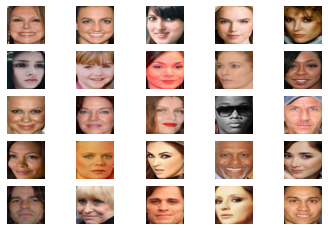

In [6]:
directory = "/content/drive/My Drive/img_align_celeba.zip (Unzipped Files)/img_align_celeba"
faces = load_faces(directory,500)
savez_compressed("celeb_faces_only.npz", faces)
plot_faces(faces,5)

In [ ]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 2.6MB/s 


In [7]:
# Extracting only the faces from the celeb faces dataset
def get_face(model,pixels,output_size=(80,80)):
  faces = model.detect_faces(pixels)
  if len(faces) == 0 :
    return None
  x1,y1,width,height = faces[0]['box']
  x1,y1 = abs(x1), abs(y1)
  x2,y2 = x1 + width , y1 + height
  face_pixels = pixels[y1:y2,x1:x2]
  img = Image.fromarray(face_pixels)
  img = img.resize(output_size)
  face_array = np.asarray(img)
  return face_array

In [8]:
def discriminator_model(input_shape=(80,80,3)):
  model = Sequential()
  model.add(Conv2D(128,(5,5),padding="same",input_shape = input_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(128,(5,5),strides = (2,2),padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(128,(5,5),strides = (2,2),padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(128,(5,5),strides = (2,2),padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(128,(5,5),strides = (2,2),padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Flatten()) 
  model.add(Dropout(0.4))
  model.add(Dense(1, activation="sigmoid"))
  optimizer = Adam(learning_rate=0.0002, beta_1 = 0.5)
  model.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=["accuracy"])
  return model

In [9]:
def generator_model(latent_dim):
  model = Sequential()
  n_nodes = 128 * 5 * 5
  model.add(Dense(n_nodes,input_dim = latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((5,5,128)))
  model.add(Conv2DTranspose(128,(4,4), strides=(2,2),padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2DTranspose(128,(4,4), strides=(2,2),padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2DTranspose(128,(4,4), strides=(2,2),padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2DTranspose(128,(4,4), strides=(2,2),padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(3,(5,5),activation="tanh",padding="same"))
  return model

In [10]:
def gan_model(generator, discriminator):
  model = Sequential()
  discriminator.trainable = False
  model.add(generator)
  model.add(discriminator)
  optimizer = Adam(learning_rate=0.0002, beta_1 = 0.5)
  model.compile(loss="binary_crossentropy", optimizer=optimizer)
  return model

In [11]:
# Load and scale the real samples
def load_real_faces():
  face_data = load("celeb_faces_only.npz")
  faces = face_data["arr_0"]
  X = faces.astype("float32")
  X = (X-127.5) / 127.5
  return X

In [12]:
def select_real_samples(dataset, n_samples):
  idx = randint(0,dataset.shape[0],n_samples)
  X = dataset[idx]
  y = np.ones((n_samples,1))
  return X,y

In [3]:
def generate_latent_points(latent_dim, n_samples):
  inp = randn(latent_dim * n_samples)
  X = inp.reshape(n_samples,latent_dim)
  return X

In [14]:
def generate_fake_samples(generator,latent_dim, n_samples):
  x_input = generate_latent_points(latent_dim,n_samples)
  x_output = generator.predict(x_input)
  y = np.zeros((n_samples,1))
  return x_output,y

In [21]:
def train_gan(generator, discriminator, gan_model,dataset, latent_dim,n_epochs=100,n_batches=10):
  batches_per_epoch = int(dataset.shape[0] / n_batches)
  half_batch = int(n_batches / 2)
  for i in range(n_epochs):
    for j in range(batches_per_epoch):
      x_real,y_real = select_real_samples(dataset, half_batch)
      d_loss1, _ = discriminator.train_on_batch(x_real, y_real)
      x_fake,y_fake = generate_fake_samples(generator,latent_dim, half_batch)
      d_loss2, _ = discriminator.train_on_batch(x_fake, y_fake)
      x_gan = generate_latent_points(latent_dim,n_batches)
      y_gan = np.ones((n_batches,1))
      g_loss = gan_model.train_on_batch(x_gan,y_gan)
      print("Epoch " + str(i) + " Batch " + str(j) + " Loss on real "+ str(d_loss1)+ " loss on fake " + str(d_loss2)+ " generator loss " + str(g_loss))
    if (i + 1) % 5 == 0 :
      summarize_model_performance(i, generator, discriminator, dataset, latent_dim)


In [22]:
def summarize_model_performance(i, generator, discriminator, dataset, latent_dim, n_samples=50):
  x_real, y_real = select_real_samples(dataset,n_samples)
  _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
  x_fake, y_fake = generate_fake_samples(generator,latent_dim, n_samples)
  _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose = 0)
  print("Accuracy on real " + str(acc_real) + " Accuracy on fake " + str(acc_fake))
  x_fake = (x_fake + 1) / 2.0
  for k in range(5*5):
    plt.subplot(5,5,1+k)
    plt.axis("off")
    plt.imshow(x_fake[k])
  image_name = "generated_plot_e%03d.png" % (i+1)
  plt.savefig(image_name)
  plt.close()
  model_name = "generated_model_e%03d.h5" % (i+1)
  generator.save(model_name)

In [7]:
latent_dim = 100
discriminator = discriminator_model()
generator = generator_model(latent_dim)
gan = gan_model(generator, discriminator)
dataset = load_real_faces()
train_gan(generator, discriminator, gan,dataset, latent_dim,n_epochs=100,n_batches=10)


NameError: ignored

In [4]:
generator = load_model("generated_model_e100.h5")

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


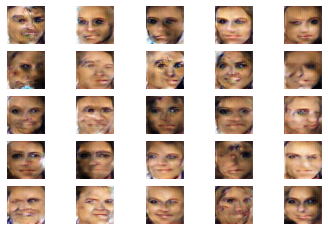

In [9]:
latent_points = generate_latent_points(100,30)
x = generator.predict(latent_points)
x = (x+1) / 2.0
for i in range(5*5):
  plt.subplot(5,5,i+1)
  plt.axis("off")
  plt.imshow(x[i,:,:])
plt.show()

In [12]:
def interpolate_points(p1,p2,n_steps=10):
  ratios = np.linspace(0,1, num=n_steps)
  vectors = list()
  vectors_r = list()
  for ratio in ratios:
    v = (1.0 - ratio) * p1 + ratio * p2 
    vectors.append(v)
  return np.asarray(vectors)

(10, 100)


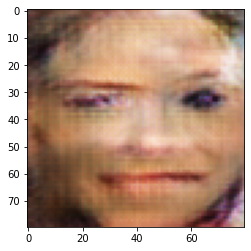

In [31]:
points = generate_latent_points(100,2)
interpolated_points = interpolate_points(points[0], points[1])
print(interpolated_points.shape)

"""for i in range(0,20,2):
  interpolated_points = interpolate_points(points[i], points[i+1])
  x = generator.predict(interpolated_points)
  x = (x+1) / 2.0
  if img_final is None:
    img_final = x
  else:
    img_final = vstack((img_final,x))"""
x = generator.predict(interpolated_points)
x = (x+1) / 2.0

for i in range(len(interpolated_points)):
  plt.imshow(x[i,:,:])
  plt.savefig(str(i) + "one.png")
plt.show()





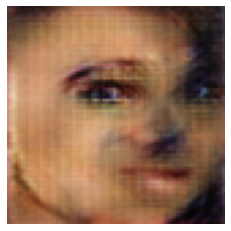

In [32]:
i_p = np.flipud(interpolated_points) 
x = generator.predict(i_p)
x = (x+1) / 2.0

for i in range(len(interpolated_points)):
  #plt.subplot(1,len(interpolated_points),1+i)
  plt.axis("off")
  plt.imshow(x[i,:,:])
  plt.savefig(str(i+9) + "one.png")
plt.show()

Vector Arithmetic in Faces

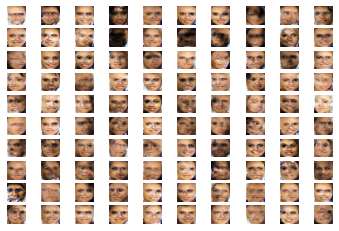

In [7]:
hundred_latent_points = generate_latent_points(100,100)
savez_compressed("100_latent_points.npz",hundred_latent_points)
X = generator.predict(hundred_latent_points)
X = (X+1) / 2.0
for i in range(10 * 10):
  plt.subplot(10,10,1+i)
  plt.axis("off")
  plt.imshow(X[i,:,:])
plt.savefig("generated_100_faces.png")
plt.show()


In [19]:
smiling_woman_face = [3,99,52]
neutral_woman_face = [85,39,89]
neutral_man_face = [37,32,80]
latent_data = load("100_latent_points.npz")
points = latent_data["arr_0"]

In [16]:
def average_points(points, idx):
  zero_idx = [i-1 for i in idx]
  vectors = points[zero_idx]
  avg_vector = np.mean(vectors, axis=0)
  all_vectors = vstack((vectors,avg_vector))
  return all_vectors

In [20]:
smiling_woman_face = average_points(points,smiling_woman_face)
neutral_woman_face = average_points(points, neutral_woman_face)
neutral_man_face = average_points(points,neutral_man_face)



[2, 98, 51]
[84, 38, 88]
[36, 31, 79]


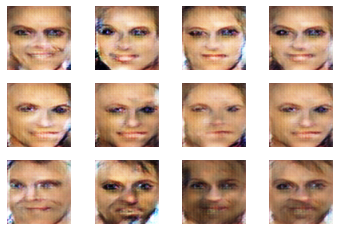

In [24]:
all_vectors = vstack((smiling_woman_face, neutral_woman_face, neutral_man_face))
images = generator.predict(all_vectors)
images = (images + 1) / 2.0
for i in range(3 * 4):
  plt.subplot(3,4,1+i)
  plt.axis("off")
  plt.imshow(images[i,:,:])
plt.savefig("generated__faces.png")
plt.show()


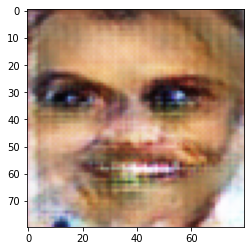

In [27]:
resulting_vector = smiling_woman_face[0] - neutral_woman_face[-1] + neutral_man_face[-1]
resulting_vector = np.expand_dims(resulting_vector,0)
resulting_image = generator.predict(resulting_vector)
resulting_image = (resulting_image + 1) / 2.0
plt.imshow(resulting_image[0])
